In [1]:
print("hi")

hi


In [2]:
!git clone https://github.com/ShubhamMishra1611/CNN_DOA.git

Cloning into 'CNN_DOA'...
remote: Enumerating objects: 55757, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 55757 (delta 17), reused 17 (delta 15), pack-reused 55734
Receiving objects: 100% (55757/55757), 370.48 MiB | 11.39 MiB/s, done.
Resolving deltas: 100% (1262/1262), done.
Updating files: 100% (53925/53925), done.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
from extract_audio import extractAudiodata
from utils import sorted_nicely
from calcs import featureExtractor2, computeSI
from model import get_model

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import IPython.display as ipd
from pathlib import Path
from tqdm import tqdm # Progress bar
import sklearn
import re
import os
import csv

plt.style.use('seaborn')

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)

<ipython-input-4-90c027e17382>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.15.0


In [7]:
# This function evaluates the custom accuracity: adjacent classes are considered correct predictions
def computeCustomAccuracy(Gamma_container_test, intTestLabels, resolution, model):

  # Predict
  preds = model.predict(Gamma_container_test)

  # Convert the predictions from one-hot to categorical
  res = np.zeros([preds.shape[0]])
  for i in range(0, preds.shape[0]):
    predClass = np.argmax(preds[i])
    res[i] = predClass

  # Init custom accuracy
  customAcc = 0

  # Variables used to account for the cyclic nature of the problem
  bottomLimitValue = int(360/resolution - 1)
  upperLimitBound = int(360/resolution)

  for i in range(0, res.shape[0]):
    # Create a range we the prediction is considered correct: actual class +- 1
    validRange = np.array([intTestLabels[i,0]-1, intTestLabels[i,0], intTestLabels[i,0]+1]).astype(int)

    # Implementing modularity
    for j in range(validRange.shape[0]):
        if validRange[j] == -1: # If we go beyond the lowest class
          validRange[j] = bottomLimitValue # Substitute with the highest
        if validRange[j] == upperLimitBound: # If we go beyond the highest class
          validRange[j] = 0 # Substitute with the lowest

    # If the predicted value is in the designated range: correct prediction
    if res[i] in validRange:
      customAcc += 1

  # Compute persentage
  customAcc = customAcc / res.shape[0] * 100

  return customAcc

In [20]:
# This function computes the default accuracy and the custom accuracy given the root folder of the test dataset
def accuracyGenerator(rootdir, modelRes30, modelRes10, sr, duration):
  # Extract all the subdirectories in rootdir
  subdirs = sorted_nicely(os.listdir(rootdir))

  # Generate the absolute path of the testing directories
  testDirectories = []
  for subdir in subdirs:
    testDirectories.append(rootdir + '/' +  subdir)

  # Init lists to contain all the accuracy values for the two models
  accuraciesRes30 = [] # Default accuracy model res 30
  customAccuraciesRes30 = [] # Custom accuracy model res 30
  accuraciesRes10 = [] # Default accuracy model res 10
  customAccuraciesRes10 = [] # Custom accuracy model res 10

  for dir in testDirectories:
    # Extract all the files' paths
    audiofiles_test = [str(file) for file in Path(dir).glob('SA*.wav')]
    audiofiles_test = sorted_nicely(audiofiles_test)

    # Extract audio data and labels
    testAudioMatrix, sourceIDs, testlabels30, testlabels10 = extractAudiodata(audiofiles_test, sr*duration)

    # Cast labels as integers
    intTestLabels30 = np.array(testlabels30, dtype='uint8')
    intTestLabels10 = np.array(testlabels10, dtype='uint8')

    # Extract the features
    datapointsNum = testAudioMatrix.shape[-1]
    Gamma_container_test = np.zeros([datapointsNum, 14, 511, 10])

    for i in range(0, datapointsNum):
      Gamma_container_test[i,:,:,:] = featureExtractor2(testAudioMatrix[:,:,i])

    # Evaluate model res 30
    # evaluationRes30 = modelRes30.evaluate(Gamma_container_test, intTestLabels30)
    # accuraciesRes30.append(evaluationRes30[1] * 100)

    # customAccRes30 = computeCustomAccuracy(Gamma_container_test, intTestLabels30, 30, modelRes30)
    # customAccuraciesRes30.append(customAccRes30)

    # Evaluate model res 10
    evaluationRes10 = modelRes10.evaluate(Gamma_container_test, intTestLabels10)
    accuraciesRes10.append(evaluationRes10[1] * 100)

    customAccRes10 = computeCustomAccuracy(Gamma_container_test, intTestLabels10, 10, modelRes10)
    customAccuraciesRes10.append(customAccRes10)

  return accuraciesRes30, customAccuraciesRes30, accuraciesRes10, customAccuraciesRes10

In [14]:
!cp -r "/content/drive/MyDrive/model_cnn_dense.zip" "/content/"
!cp -r "/content/drive/MyDrive/model_residual.zip" "/content/"

In [15]:
!unzip '/content/model_cnn_dense.zip' -d '/content/'

Archive:  /content/model_cnn_dense.zip
   creating: /content/content/model/
  inflating: /content/content/model/keras_metadata.pb  
   creating: /content/content/model/assets/
  inflating: /content/content/model/saved_model.pb  
   creating: /content/content/model/variables/
  inflating: /content/content/model/variables/variables.index  
  inflating: /content/content/model/variables/variables.data-00000-of-00001  
 extracting: /content/content/model/fingerprint.pb  


In [16]:
!unzip '/content/model_residual.zip' -d '/content/content2'

Archive:  /content/model_residual.zip
   creating: /content/content2/content/model/
  inflating: /content/content2/content/model/keras_metadata.pb  
   creating: /content/content2/content/model/assets/
  inflating: /content/content2/content/model/saved_model.pb  
   creating: /content/content2/content/model/variables/
  inflating: /content/content2/content/model/variables/variables.index  
  inflating: /content/content2/content/model/variables/variables.data-00000-of-00001  
 extracting: /content/content2/content/model/fingerprint.pb  


In [17]:
# Models loading
sr = 16000
duration = 0.5

optimizer = keras.optimizers.Adam(learning_rate=1e-5)

model_CNN_dense = keras.models.load_model(r'/content/content/model')
model_CNN_dense.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)

model_CNN_residual = keras.models.load_model(r'/content/content2/content/model')
model_CNN_residual.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)

In [18]:
room_dim = [9.64, 7.04, 2.95] # Initial room dimensions
xy_ratio = room_dim[0] / room_dim[1] # x/y ratio
zy_ratio = room_dim[2] / room_dim[1] # z/y ratio

y_i = 1.6 # Initial value for the y-dim
y_f = 15 # Final value for the y-dim
y_steps = np.linspace(y_i, y_f, 20) # Subdividing testing range in 20 steps

# Computing volumes for increasing y
volumes = []
for i in range(0, y_steps.shape[0]):
  y = y_steps[i]
  x = xy_ratio * y
  z = zy_ratio * y
  volumes.append(x*y*z)
  print('Room {} has dimensions [{:.2f}, {:.2f}, {:.2f}][m] --> volume = {:.2f} [m^3]'.format(i+1, x, y, z, volumes[i]))

Room 1 has dimensions [2.19, 1.60, 0.67][m] --> volume = 2.35 [m^3]
Room 2 has dimensions [3.16, 2.31, 0.97][m] --> volume = 7.03 [m^3]
Room 3 has dimensions [4.12, 3.01, 1.26][m] --> volume = 15.66 [m^3]
Room 4 has dimensions [5.09, 3.72, 1.56][m] --> volume = 29.44 [m^3]
Room 5 has dimensions [6.05, 4.42, 1.85][m] --> volume = 49.58 [m^3]
Room 6 has dimensions [7.02, 5.13, 2.15][m] --> volume = 77.30 [m^3]
Room 7 has dimensions [7.99, 5.83, 2.44][m] --> volume = 113.79 [m^3]
Room 8 has dimensions [8.95, 6.54, 2.74][m] --> volume = 160.27 [m^3]
Room 9 has dimensions [9.92, 7.24, 3.03][m] --> volume = 217.95 [m^3]
Room 10 has dimensions [10.88, 7.95, 3.33][m] --> volume = 288.02 [m^3]
Room 11 has dimensions [11.85, 8.65, 3.63][m] --> volume = 371.70 [m^3]
Room 12 has dimensions [12.81, 9.36, 3.92][m] --> volume = 470.21 [m^3]
Room 13 has dimensions [13.78, 10.06, 4.22][m] --> volume = 584.73 [m^3]
Room 14 has dimensions [14.75, 10.77, 4.51][m] --> volume = 716.49 [m^3]
Room 15 has dime

In [21]:
rootdir_RV = '/content/CNN_DOA/DATASETS/ROOM_VOLUME'

# Compute accuracies
_, _, accRes10_RV, custAccRes10_RV = accuracyGenerator(rootdir_RV,None,model_CNN_residual,sr,duration)

100%|██████████| 100/100 [00:10<00:00,  9.66it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 534.31it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 504.51it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 451.92it/s]


4/4 [==============================] - 0s 24ms/step


100%|██████████| 100/100 [00:00<00:00, 415.97it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 457.18it/s]


4/4 [==============================] - 0s 26ms/step


100%|██████████| 100/100 [00:00<00:00, 487.06it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 563.07it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 515.78it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 542.91it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 525.94it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 484.67it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 516.47it/s]


4/4 [==============================] - 0s 24ms/step


100%|██████████| 100/100 [00:00<00:00, 486.45it/s]


4/4 [==============================] - 0s 24ms/step


100%|██████████| 100/100 [00:00<00:00, 432.88it/s]


4/4 [==============================] - 0s 24ms/step


100%|██████████| 100/100 [00:00<00:00, 382.63it/s]


4/4 [==============================] - 0s 24ms/step


100%|██████████| 100/100 [00:00<00:00, 503.68it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 454.84it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 468.97it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 473.47it/s]


4/4 [==============================] - 0s 25ms/step


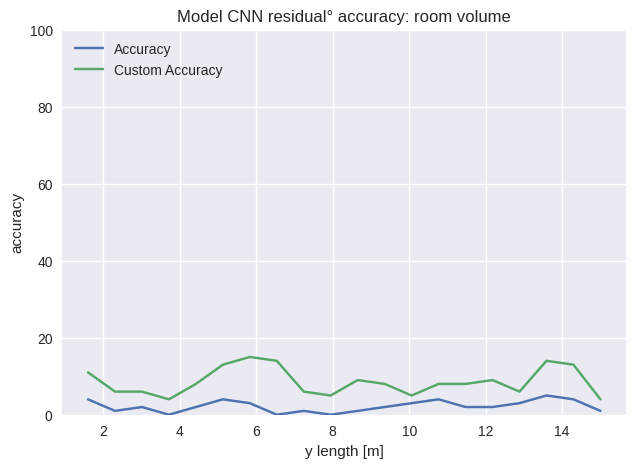

In [24]:
# Plotting the results
plt.figure(figsize=(16,5))

# Model CNN residual
plt.subplot(1,2,1)
plt.plot(y_steps, accRes10_RV)
plt.plot(y_steps, custAccRes10_RV)
plt.title('Model CNN residual° accuracy: room volume')
plt.ylabel('accuracy')
plt.xlabel('y length [m]')
plt.ylim([0,100])
plt.legend(['Accuracy', 'Custom Accuracy'], loc='upper left')

# # Model CNN dense
# plt.subplot(1,2,2)
# plt.plot(y_steps, accRes30_RV)
# plt.plot(y_steps, custAccRes30_RV)
# plt.title('Model CNN Dense accuracy: room volume')
# plt.ylabel('accuracy')
# plt.xlabel('y length [m]')
# plt.ylim([0,100])
# plt.legend(['Accuracy', 'Custom Accuracy'], loc='upper left')

In [25]:
plt.savefig('Test_plot_rv_residual.png')
plt.show()

<Figure size 800x550 with 0 Axes>

In [26]:
# # Creating csv file for results
# header = ['test_range', 'accuracy'] # Columns' names

# # Exporting data for model res 30°
# with open('vol_res30.csv', 'w') as f:
#     writer = csv.writer(f)

#     # write the header
#     writer.writerow(header)

#     for i in range(0, len(custAccRes30_RV)):
#       row = [y_steps[i], custAccRes30_RV[i]]
#       # write the data
#       writer.writerow(row)

# # Exporting data for model res 10°
# with open('vol_res10.csv', 'w') as f:
#     writer = csv.writer(f)

#     # write the header
#     writer.writerow(header)

#     for i in range(0, len(custAccRes10_RV)):
#       row = [y_steps[i], custAccRes10_RV[i]]
#       # write the data
#       writer.writerow(row)

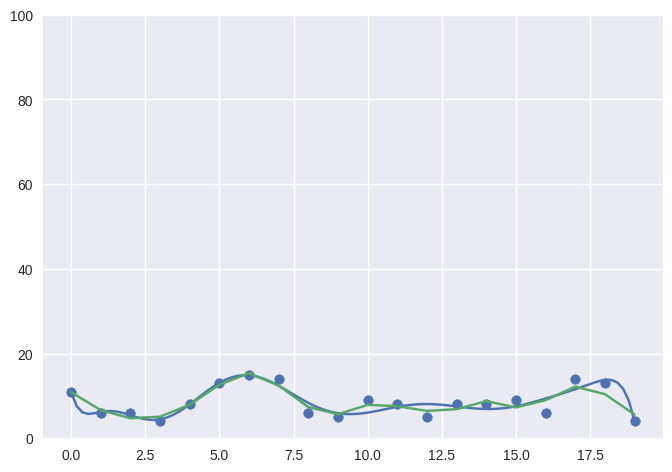

In [ ]:
# TESTING polynomial fitting (skip/remove)
from scipy.signal import savgol_filter
custAccRes10_RV = np.asarray(custAccRes10_RV)
x = np.arange(0,20)
y = custAccRes10_RV

y_sav = savgol_filter(y, 5, 2)

mymodel = np.poly1d(np.polyfit(x, y, 11))
myline = np.linspace(0, 19, 100)
plt.scatter(x, y)
plt.plot(myline, mymodel(myline))
plt.plot(y_sav)
plt.ylim([0,100])
plt.show()

In [27]:
source_distances = np.linspace(0.14, 6.94, num = 20)
print(source_distances)

[0.14       0.49789474 0.85578947 1.21368421 1.57157895 1.92947368
 2.28736842 2.64526316 3.00315789 3.36105263 3.71894737 4.07684211
 4.43473684 4.79263158 5.15052632 5.50842105 5.86631579 6.22421053
 6.58210526 6.94      ]


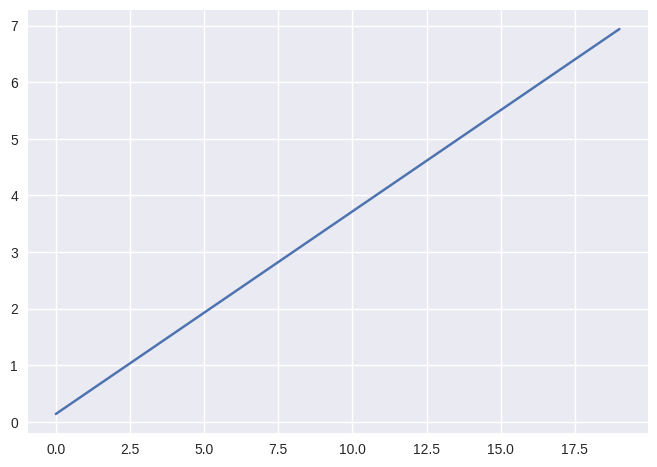

In [29]:
plt.plot(source_distances)

In [31]:
rootdir_SD = '/content/CNN_DOA/DATASETS/SOURCE_DISTANCE'

# Compute accuracies
_, _, accRes10_SD, custAccRes10_SD = accuracyGenerator(rootdir_SD, None, model_CNN_residual, sr, duration)

100%|██████████| 100/100 [00:00<00:00, 734.69it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 474.03it/s]


4/4 [==============================] - 0s 21ms/step


100%|██████████| 100/100 [00:00<00:00, 783.33it/s]


4/4 [==============================] - 0s 24ms/step


100%|██████████| 100/100 [00:00<00:00, 562.34it/s]


4/4 [==============================] - 0s 25ms/step


100%|██████████| 100/100 [00:00<00:00, 521.18it/s]


4/4 [==============================] - 0s 25ms/step


100%|██████████| 100/100 [00:00<00:00, 483.35it/s]


4/4 [==============================] - 0s 24ms/step


100%|██████████| 100/100 [00:00<00:00, 851.78it/s]


4/4 [==============================] - 0s 28ms/step


100%|██████████| 100/100 [00:00<00:00, 585.01it/s]


4/4 [==============================] - 0s 24ms/step


100%|██████████| 100/100 [00:00<00:00, 793.46it/s]


4/4 [==============================] - 0s 24ms/step


100%|██████████| 100/100 [00:00<00:00, 679.48it/s]


4/4 [==============================] - 0s 24ms/step


100%|██████████| 100/100 [00:00<00:00, 752.41it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 767.84it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 804.93it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 423.48it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 489.48it/s]


4/4 [==============================] - 0s 26ms/step


100%|██████████| 100/100 [00:00<00:00, 411.39it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 569.20it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 550.12it/s]


4/4 [==============================] - 0s 24ms/step


100%|██████████| 100/100 [00:00<00:00, 568.86it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 531.63it/s]


4/4 [==============================] - 0s 23ms/step


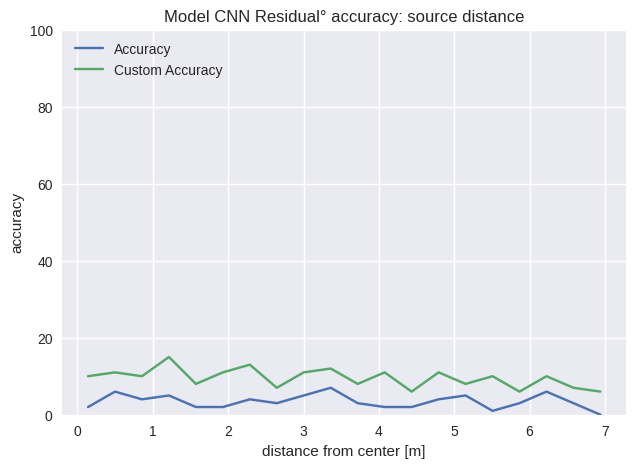

In [32]:
# Plotting results
plt.figure(figsize=(16,5))

# Model res 10
plt.subplot(1,2,1)
plt.plot(source_distances, accRes10_SD)
plt.plot(source_distances, custAccRes10_SD)
plt.title('Model CNN Residual° accuracy: source distance')
plt.ylabel('accuracy')
plt.xlabel('distance from center [m]')
plt.ylim([0,100])
plt.legend(['Accuracy', 'Custom Accuracy'], loc='upper left')

# Model res 30
# plt.subplot(1,2,2)
# plt.plot(source_distances, accRes30_SD)
# plt.plot(source_distances, custAccRes30_SD)
# plt.title('Model CNN dense accuracy: source distance')
# plt.ylabel('accuracy')
# plt.xlabel('distance from center [m]')
# plt.ylim([0,100])
# plt.legend(['Accuracy', 'Custom Accuracy'], loc='upper left')

In [ ]:
# # Creating csv file for results
# header = ['test_range', 'accuracy'] # Columns' names

# # Exporting data for model res 30°
# with open('source_res30.csv', 'w') as f:
#     writer = csv.writer(f)

#     # write the header
#     writer.writerow(header)

#     for i in range(0, len(custAccRes30_SD)):
#       row = [source_distances[i], custAccRes30_SD[i]]
#       # write the data
#       writer.writerow(row)

# # Exporting data for model res 10°
# with open('source_res10.csv', 'w') as f:
#     writer = csv.writer(f)

#     # write the header
#     writer.writerow(header)

#     for i in range(0, len(custAccRes10_SD)):
#       row = [source_distances[i], custAccRes10_SD[i]]
#       # write the data
#       writer.writerow(row)

In [33]:
p_i = [4.82, 3.52, 1.5] # Inital position
p_f = [8, 5.4, 0.14] # Final position
steps = 20 # Number of subdivisions
# Spanning over the three dimensions
positions = np.asarray([np.linspace(p_i[0], p_f[0], steps), np.linspace(p_i[1], p_f[1], steps), np.linspace(p_i[2], p_f[2], steps)]).T

# Computing the distances from p_i, first position
distances = []
for pos in positions:
  # Euclidean distance
  dist = np.sqrt(np.power(p_i[0] - pos[0], 2) + np.power(p_i[0] - pos[0], 2) + np.power(p_i[0] - pos[0], 2))
  distances.append(dist)

print(distances)

[0.0, 0.2898906088457385, 0.579781217691477, 0.8696718265372154, 1.159562435382954, 1.4494530442286924, 1.7393436530744308, 2.029234261920168, 2.319124870765908, 2.6090154796116445, 2.8989060884573847, 3.1887966973031214, 3.47868730614886, 3.7685779149945984, 4.058468523840337, 4.348359132686075, 4.638249741531814, 4.928140350377553, 5.218030959223291, 5.507921568069029]


In [34]:
rootdir_RP = '/content/CNN_DOA/DATASETS/RECEIVER_POS'

_, _, accRes10_RP, custAccRes10_RP = accuracyGenerator(rootdir_RP, None, model_CNN_residual, sr, duration)

100%|██████████| 100/100 [00:00<00:00, 343.91it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 526.66it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 523.84it/s]


4/4 [==============================] - 0s 24ms/step


100%|██████████| 100/100 [00:00<00:00, 415.07it/s]


4/4 [==============================] - 0s 25ms/step


100%|██████████| 100/100 [00:00<00:00, 362.91it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 508.22it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 546.89it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 498.56it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 519.20it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 509.53it/s]


4/4 [==============================] - 0s 24ms/step


100%|██████████| 100/100 [00:00<00:00, 559.53it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 527.31it/s]


4/4 [==============================] - 0s 24ms/step


100%|██████████| 100/100 [00:00<00:00, 405.97it/s]


4/4 [==============================] - 0s 24ms/step


100%|██████████| 100/100 [00:00<00:00, 437.42it/s]


4/4 [==============================] - 0s 26ms/step


100%|██████████| 100/100 [00:00<00:00, 343.43it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 510.81it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 529.67it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 510.95it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 511.36it/s]


4/4 [==============================] - 0s 23ms/step


100%|██████████| 100/100 [00:00<00:00, 519.75it/s]


4/4 [==============================] - 0s 24ms/step


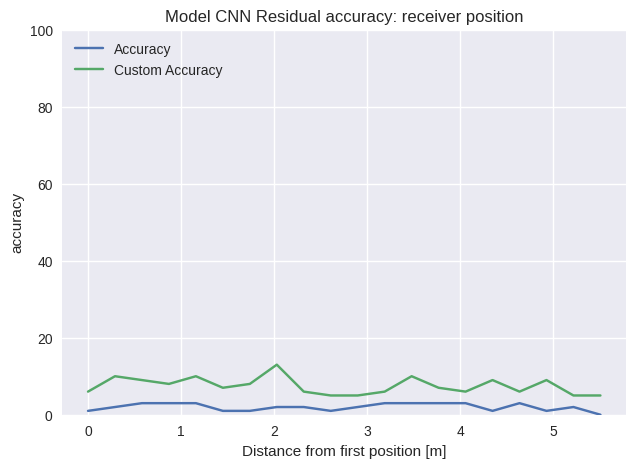

In [35]:
# Plotting results
plt.figure(figsize=(16,5))

# Model res 10
plt.subplot(1,2,1)
plt.plot(distances, accRes10_RP)
plt.plot(distances, custAccRes10_RP)
plt.title('Model CNN Residual accuracy: receiver position')
plt.ylabel('accuracy')
plt.xlabel('Distance from first position [m]')
plt.ylim([0,100])
plt.legend(['Accuracy', 'Custom Accuracy'], loc='upper left')

# # Model res 30
# plt.subplot(1,2,2)
# plt.plot(distances, accRes30_RP)
# plt.plot(distances, custAccRes30_RP)
# plt.title('Model CNN dense accuracy: receiver position')
# plt.ylabel('accuracy')
# plt.xlabel('Distance from first position [m]')
# plt.ylim([0,100])
# plt.legend(['Accuracy', 'Custom Accuracy'], loc='upper left')

In [36]:
rootdir_RV = '/content/CNN_DOA/DATASETS/ROOM_VOLUME'

# Compute accuracies
_, _, accRes10_RV, custAccRes10_RV = accuracyGenerator(rootdir_RV,None,model_CNN_dense,sr,duration)

100%|██████████| 100/100 [00:00<00:00, 465.96it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 720.69it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 756.25it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 738.70it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 756.93it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 732.55it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 792.34it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 726.24it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 191.20it/s]


4/4 [==============================] - 0s 14ms/step


100%|██████████| 100/100 [00:00<00:00, 438.46it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 749.89it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 746.84it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 797.92it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 729.91it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 792.84it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 749.17it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 765.86it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 555.64it/s]


4/4 [==============================] - 0s 14ms/step


100%|██████████| 100/100 [00:00<00:00, 548.97it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 565.01it/s]


4/4 [==============================] - 0s 12ms/step


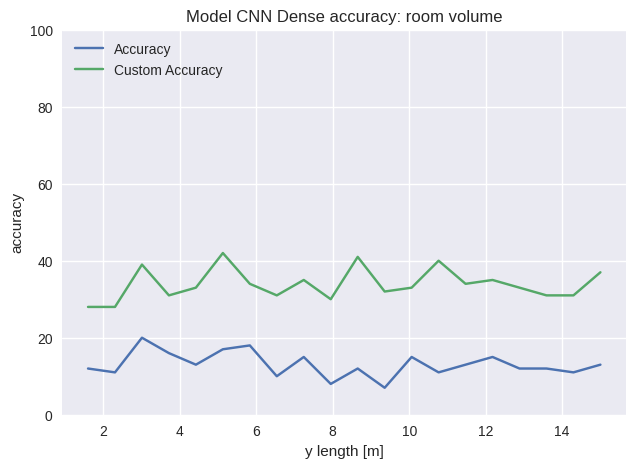

In [37]:
# Plotting the results
plt.figure(figsize=(16,5))

# Model CNN residual
plt.subplot(1,2,1)
plt.plot(y_steps, accRes10_RV)
plt.plot(y_steps, custAccRes10_RV)
plt.title('Model CNN Dense accuracy: room volume')
plt.ylabel('accuracy')
plt.xlabel('y length [m]')
plt.ylim([0,100])
plt.legend(['Accuracy', 'Custom Accuracy'], loc='upper left')

In [38]:
rootdir_SD = '/content/CNN_DOA/DATASETS/SOURCE_DISTANCE'

# Compute accuracies
_, _, accRes10_SD, custAccRes10_SD = accuracyGenerator(rootdir_SD, None, model_CNN_dense, sr, duration)

100%|██████████| 100/100 [00:00<00:00, 378.59it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 792.14it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 745.45it/s]


4/4 [==============================] - 0s 14ms/step


100%|██████████| 100/100 [00:00<00:00, 548.63it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 555.39it/s]


4/4 [==============================] - 0s 14ms/step


100%|██████████| 100/100 [00:00<00:00, 507.39it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 823.18it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 587.20it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 822.80it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 379.89it/s]


4/4 [==============================] - 0s 14ms/step


100%|██████████| 100/100 [00:00<00:00, 784.33it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 758.53it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 782.69it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 714.85it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 573.60it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 545.69it/s]


4/4 [==============================] - 0s 14ms/step


100%|██████████| 100/100 [00:00<00:00, 432.77it/s]


4/4 [==============================] - 0s 24ms/step


100%|██████████| 100/100 [00:00<00:00, 146.54it/s]


4/4 [==============================] - 0s 14ms/step


100%|██████████| 100/100 [00:00<00:00, 464.56it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 764.58it/s]


4/4 [==============================] - 0s 13ms/step


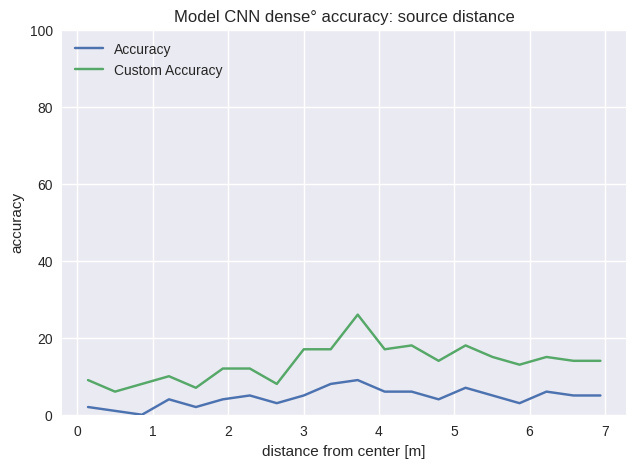

In [39]:
plt.figure(figsize=(16,5))

# Model res 10
plt.subplot(1,2,1)
plt.plot(source_distances, accRes10_SD)
plt.plot(source_distances, custAccRes10_SD)
plt.title('Model CNN dense° accuracy: source distance')
plt.ylabel('accuracy')
plt.xlabel('distance from center [m]')
plt.ylim([0,100])
plt.legend(['Accuracy', 'Custom Accuracy'], loc='upper left')

In [40]:
rootdir_RP = '/content/CNN_DOA/DATASETS/RECEIVER_POS'

_, _, accRes10_RP, custAccRes10_RP = accuracyGenerator(rootdir_RP, None, model_CNN_dense, sr, duration)

100%|██████████| 100/100 [00:00<00:00, 382.97it/s]


4/4 [==============================] - 0s 15ms/step


100%|██████████| 100/100 [00:00<00:00, 485.74it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 557.25it/s]


4/4 [==============================] - 0s 14ms/step


100%|██████████| 100/100 [00:00<00:00, 505.61it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 711.43it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 819.80it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 698.80it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 780.57it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 722.99it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 405.64it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 799.92it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 740.72it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 809.63it/s]


4/4 [==============================] - 0s 19ms/step


100%|██████████| 100/100 [00:00<00:00, 240.47it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 506.37it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 430.19it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 730.85it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 687.07it/s]


4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [00:00<00:00, 470.54it/s]


4/4 [==============================] - 0s 12ms/step


100%|██████████| 100/100 [00:00<00:00, 738.48it/s]


4/4 [==============================] - 0s 13ms/step


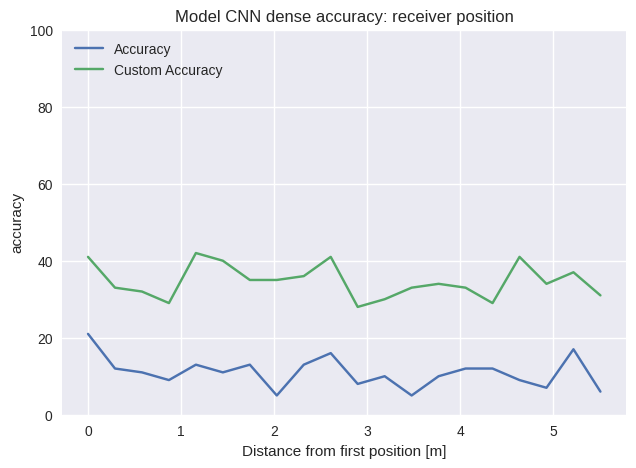

In [41]:
# Plotting results
plt.figure(figsize=(16,5))

# Model res 10
plt.subplot(1,2,1)
plt.plot(distances, accRes10_RP)
plt.plot(distances, custAccRes10_RP)
plt.title('Model CNN dense accuracy: receiver position')
plt.ylabel('accuracy')
plt.xlabel('Distance from first position [m]')
plt.ylim([0,100])
plt.legend(['Accuracy', 'Custom Accuracy'], loc='upper left')